In [23]:
# !python --version
# !pip install OMADS
# !pip install git+https://github.com/Ahmed-Bayoumy/DMDO
import OMADS
from DMDO import *
from typing import Dict, List
import numpy as np
import math
import copy
from matplotlib import pyplot as plt


# Distributed multidisciplinary design optimization

As the complexity of engineering systems grows, the engineering design task becomes more challenging due to distributed design processes that mostly rely on big historical data and/or experts opinion. Multidisciplinary design optimization (MDO) aims at leveraging system's performance that relies on the evaluated design criteria of several disciplines and processes. MDO is critical to coordinating concurrent analysis and design activities in order to account for and exploit the interactions of multiple physics-based engineering disciplines such as aerodynamics, structures, thermodynamics, etc., as well as the disciplines pertinent to life-cycle aspects. For instance, Figure 1 shows the coupling relationships among various interacting disciplines in the design process of the supersonic business jet system that includes recursive workflows, which usually don't converge, and shared design variables.

<figure>
  <center><p><img src="Figures/realistic_MDO.png"
    width="500" height="400" align="middle">
  <figcaption>Fig.1 Data dependencies for business jet problem. Single arrows indicate direction of response flow, and double arrows indicate shared variables [1].</figcaption>
</figure>

[1] Tosserams, S., Michael Kokkolaras, L. F. P. Etman, and J. E. Rooda. "A nonhierarchical formulation of analytical target cascading." Journal of Mechanical Design 132, no. 5 (2010).


# When to use IDF architecture
Solving one large MDO problem all-in-one works great if the multidisciplinary (system) analysis (MDA) converges, so the following checklist will help you to decide whether using DMDO is a recommended choice.

* For single- and multi-objective studies, use DMDO if any of the following conditions is met

  * If the MDA process doesn't converge (MDA typically does not converge for tightly-coupled systems)
  * If the optimization algorithm used cannot exploit available disciplinary knowledge (if any)
  * If the optimization algorithm cannot handle large-diemnsional design space
  * If subsystems are in limbo with their unachievable targets; they cannot proceed without achieving their required targets and other subsystems at higher-levels cannot compromise their received responses

$ $
* For multi-objective studies, use DMDO if any of the following conditions is met

  * If the optimization algorithm cannot deal with large-dimensional functions space
  * If the unrealistic designs dominate the Pareto plot


## Background 

In literature, there are two main approaches to classify MDO each can be categorized into two compartments: multidisciplinary design feasible (MDF) versus independent discipline feasible (IDF) methods and monolithic versus distributed formulations. MDF methods view multidisciplinary analysis (MDA) as a `blackbox` and essentially assume that it can be solved using fixed-point iteration (FPI) [2]. 

<figure>
  <center><p><img src="Figures/Monolithic.png"
    width="200" height="300" align="middle">
  <figcaption>Fig.2 Monolithic MDO workflow: all-at-once (AAO).</figcaption>
</figure>

<figure>
  <center><p><img src="Figures/MDF_schem.png"
    width="300" height="160" align="middle">
  <figcaption>Fig.3 Interdisciplinary interation between computational fluid dynamics (CFD) and computational structural analysis (CSA).</figcaption>
</figure>

<figure>
  <center><p><img src="Figures/MDF_XDSM.png"
    width="550" height="330" align="middle">
  <figcaption>Fig.4 The extended design structure matrix (XDSM) of the MDF architecture of a fluid-structural MDO problem.</figcaption>
</figure>

IDF methods recognize that MDA is often a non-convergent process; thus, they separate disciplinary analyses by introducing auxiliary variables and consistency constraints. 

<figure>
  <center><p><img src="Figures/IDF_schem.png"
    width="400" height="200" align="middle">
  <figcaption>Fig.5 Decomposing the MDO problem into two subproblems.</figcaption>
</figure>

<figure>
  <center><p><img src="Figures/IDF_XDSM.png"
    width="600" height="430" align="middle">
  <figcaption>Fig.6 The XDSM of the IDF architecture of a fluid-structural MDO problem.</figcaption>
</figure>


This improves MDA convergence but increases problem size and difficulty. Monolithic formulations solve a single optimization problem while distributed formulations solve many coupled subproblems, each typically associated with a particular discipline or system component. Distributed IDF methods are considered state-of-the-art: they include nested formulations such as Collaborative Optimization, Bi-Level Integrated Systems Synthesis-2000, and “Quasi-Separable Decomposition; and penalty algorithms such as Analytical Target Cascading and Enhanced Collaborative Optimization. 

In the following sections we will focus on demonstrating the implementation of the non-hierarchical analytical target cascade (NHATC) method.

[2] Martins, Joaquim RRA, and Andrew B. Lambe. "Multidisciplinary design optimization: a survey of architectures." AIAA journal 51, no. 9 (2013): 2049-2075.

## NHATC

NHATC is a distributed MDO coordination method that utilizes the alternating directions method of multipliers (ADMM) to coordinate design solutions among partitioned subproblems to ensure their consistency. According to the classification of MDO architectures in Martins and Lamb review paper, it is an inexact penalty distributed IDF method. 

The main idea of the NHATC design coordination is to introduce a local copy of each variable that appears in multiple subproblems for each of those subproblems. The variable's local copies are coordinated by means of a penalty function approach.

Let us illustrate how NHATC works by means of a running example:

\begin{align*}
        \left\{
        \begin{array}{l}
        \text{min} \,\, u+v+a+b, \\
        \text{w.r.t}\,\, u,v,w, \\
        \text{s.t.}\,\, a = \log(u) + \log(v) + \log(b), \\
        \,\,\,\,\,\,\,\, b = u^{-1} + w^{-1} + a^{-1}, \\
        \,\,\,\,\,\,\,\, w +b -10 \leq 0, \\
        \,\,\,\,\,\,\,\, 0 \leq u,v,w,a,b \leq 10.
        \end{array}
        \right.
\tag{$\mathcal{P}$}
\end{align*}



<figure>
  <center><p><img src="Figures/basicMDO.png"
    width="300" height="110" aligned="middle">
  <figcaption>Fig.7 Simple MDO workflow.</figcaption>
</figure>

Let us decompose the problem into two subproblems:

<figure>
  <center><p><img src="Figures/basic_partitioned.png"
    width="320" height="110" aligned="middle">
  <figcaption>Fig 8. Partitioned simple MDO problem.</figcaption>
</figure>

The definition of subproblem 1 is

\begin{align*}
        \left\{
        \begin{array}{l}
        \text{min} \,\, u_{1} + v + a_{1} + b_{1} + \phi_{u}(u_{1}-u_{2}) + \phi_{a}(a_{1}-a_{2}) + \phi_{b}(b_{1}-b_{2}), \\
        \text{w.r.t}\,\, u_{1},v,b_{1}, \\
        \text{s.t.}\,\, a_{1} = \log(u_{1}) + \log(v_{1}) + \log(b_{1}), \\
        \,\,\,\,\,\,\,\, 0 \leq u_{1},v,a_{1},b_{1} \leq 10,
        \end{array}
        \right.
\tag{$\mathcal{p}_{1}$}
\end{align*}

and subproblem 2 is


\begin{align*}
        \left\{
        \begin{array}{l}
        \text{min} \,\, \phi_{u}(u_{1}-u_{2}) + \phi_{a}(a_{1}-a_{2}) + \phi_{b}(b_{1}-b_{2}), \\
        \text{w.r.t}\,\, u_{2},w,a_{2}, \\
        \text{s.t.}\,\, b = u^{-1}_{2} + w^{-1} + a^{-1}_{2}, \\
        \,\,\,\,\,\,\,\, w +b_{2} -10 \leq 0, \\
        \,\,\,\,\,\,\,\, 0 \leq u_{2},w,a_{2},b_{2} \leq 10.
        \end{array}
        \right.
\tag{$\mathcal{p}_{2}$}
\end{align*}


## Variable declaration

The MDO workflow shown in Figure 8 dictates that we have eight variables (after problem decomposition); two local variables $w, v$ and six copies of coupling and shared variables $u_{1}, u_{2}, a_{1}, a_{2}, b_{1}, b_{2}.$ So we start by regrouping those variables into a single variables vector

\begin{align*}
        \begin{array}{l}
        \mathbf{x} = [u_{1}, v, a_{1}, b_{1}, u_{2}, w, b_{2}, b_{2}] \in \mathbb{R}^{n_{x}}.
        \end{array}
\end{align*}

For each variable of $\mathbf{x}$, we declare the following list of attributes:

* $i$: Variable's index where $i \in \{0,1,  ...,n_{x} \}$
* $\mathbf{J}$: List of subproblem indices; this list holds the index of the subproblem where the variable $x_{i}$ appears in.
* $\mathbf{N}$: List of variable names (In DMDO, we don't assign the subproblem index to the variable name, so we introduce the variables copy by explicitly duplicating the name)
* $n_{v}$: List of each variable's dimensions
* $\mathbf{C}_{t}$: List of coupling types; it holds the coupling type w.r.t to the subproblem index (not w.r.t the linked one)
  * Shared
  * Uncoupled
  * Feedforward
  * Feedback
  * Dummy
* $\mathbf{L}$: List of subproblem links; the index of the subproblem that the variable is linked to; each variable can be assigned to a scalar integer value for a single link or a list of integer values for multiple links
* $\mathbf{x}_{0}$: The initial design point
* $\mathbf{S}$: List of scaling factors
* $\bar{\mathbf{x}}$: Variable's lower bound
* $\underline{\mathbf{x}}$: Variable's upper bound

Without loss of generality, it is recommended to define scalar variables; however in `DMDO`, variables can be vectors of any length.
Let's see how we can declare variables attributes in `DMDO`:


In [96]:
#  Variables setup
x = {}
X: List[variableData] = []
# Define variable names
N = ["u", "v", "a", "b", "u", "w", "a", "b"]
nx: int = len(N)
# Subproblem indices: Indices should be non-zero
J = [1,1,1,1,2,2,2,2]
# Subproblems links
L = [2, None, 2, 2, 1, None, 1, 1]
# Coupling types
Ct = [COUPLING_TYPE.SHARED, COUPLING_TYPE.UNCOUPLED, COUPLING_TYPE.FEEDFORWARD,
COUPLING_TYPE.FEEDBACK, COUPLING_TYPE.SHARED, COUPLING_TYPE.UNCOUPLED,
COUPLING_TYPE.FEEDBACK, COUPLING_TYPE.FEEDFORWARD]
# Lower bounds
lb = [0.]*8
# Upper bounds
ub = [10.]*8
# Baseline
x0 = [1.]*8
# Scaling
scaling = np.subtract(ub,lb)

# Inconsistency scaling
Qscaling=[]
# Create a dictionary for each variable
for i in range(nx):
  x[f"var{i+1}"] = {"index": i+1,
  "sp_index": J[i],
  f"name": N[i],
  "dim": 1,
  "value": 0.,
  "coupling_type": Ct[i],
  "link": L[i],
  "baseline": x0[i],
  "scaling": scaling[i],
  "lb": lb[i],
  "value": x0[i],
  "ub": ub[i]}
  Qscaling.append(1/scaling[i] if 1/scaling[i] != np.inf and 1/scaling[i] != np.nan else 1.)


# Instantiate the variableData class for each variable using its according dictionary
for i in range(nx):
  X.append(variableData(**x[f"var{i+1}"]))



## Disciplinary analyses

After constructing the list of the `variablesData` class instantiations, then we can instantiate the `process` class of each disciplinary analysis (DA). For the sake of simplicity, we use callable functions to execute the analysis.


In [97]:
def A1(x):
  LAMBDA = 0.0
  for i in range(len(x)):
    if x[i] == 0.:
      x[i] = 1e-12
  return math.log(x[0]+LAMBDA) + math.log(x[1]+LAMBDA) + math.log(x[2]+LAMBDA)

def A2(x):
  LAMBDA = 0.0
  for i in range(len(x)):
    if x[i] == 0.:
      x[i] = 1e-12
  return np.divide(1., (x[0]+LAMBDA)) + np.divide(1., (x[1]+LAMBDA)) + np.divide(1., (x[2]+LAMBDA))

We introduce the `variableData` along with the analysis callable functions to the DA `process` class instantiations:

\begin{align*}
        \begin{array}{l}
        [\mathbf{y}_{j}] \leftarrow A_{j}(\mathbf{x}[\mathbf{D}_{j}]).
        \end{array}
\end{align*}

In [98]:
# Analyses setup; construct disciplinary analyses
DA1: process = DA(inputs=[X[0], X[1], X[3]],
outputs=[X[2]],
blackbox=A1,
links=2,
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

DA2: process = DA(inputs=[X[4], X[5], X[6]],
outputs=[X[7]],
blackbox=A2,
links=1,
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

## Multidisciplinary analysis
The response outputs of $A_{j}(\mathbf{x}[\mathbf{D}_{j}])$ will be used to evaluate the MDA processes of each MDO subproblem.

\begin{align*}
        \begin{array}{l}
        [\mathbf{Y}_{j}] \leftarrow p_{\text{MDA}_{j}}(\mathbf{y}_{j}, \mathbf{x}[\mathbf{D}_{j}]).
        \end{array}
\end{align*}

In [99]:
# MDA setup; construct subproblems MDA
sp1_MDA: process = MDA(nAnalyses=1, analyses = [DA1], variables=[X[0], X[1], X[3]], responses=[X[2]])
sp2_MDA: process = MDA(nAnalyses=1, analyses = [DA2], variables=[X[4], X[5], X[6]], responses=[X[7]])

The vector $\mathbf{Y}_{j}$ should include all the dependent design variables including the coupling variables of the subproblem $j$ in the same order of the MDA process returned outputs.

## MDO subproblems

The MDA outputs $\mathbf{Y}_{j}$ of $p_{\text{MDA}_{j}}(\mathbf{y}_{j}, \mathbf{x}[\mathbf{D}_{j}])$ will be used to evaluate the design criteria and coupling variables of the formulated subproblem $p_{\text{MDO}_{j}}(\mathbf{Y}_{j}, \mathbf{x}[\mathbf{D}_{j}])$

\begin{align*}
        \begin{array}{l}
        [f_{j}, \mathbf{g}_{j}, \mathbf{h}_{j}, y_{c_{j}}] \leftarrow p_{\text{MDO}_{j}}(\mathbf{Y}_{j}, \mathbf{x}[\mathbf{D}_{j}]).
        \end{array}
\end{align*}

Before we illustrate how to formulate the MDO subproblems, we need to explain how the ADMM coordinator work.

## ADMM coordinator

In this section, we explain how the ADMM algorithm works and how violated inconsistency constraints are penalized.

### Defining inconsistencies

The scaled inconsistencies between each pair of linked variables are concatenated in the vector $\mathbf{q} \in \mathbb{R}^{n_{q}}$.

We use both $\mathbf{L}$ and $\mathbf{J}$ attributes to build the linking map $\mathbf{N}_{j} = [\bar{\mathbf{I}}_{j}, \underline{\mathbf{I}}_{j}]$ among variables of the MDO problem. In DMDO, the function responsible on building the linker matrix called `set_pair` which is one of the `SubProblem` class methods.


<figure>
  <center><p><img src="https://github.com/Ahmed-Bayoumy/MDO_McGill/blob/DEV/Figures/Algo1.png?raw=true"
    width="400" height="250" aligned="middle">
  <figcaption>Algorithm 1. Linker matrix.</figcaption>
</figure>

We also need to build a scaling vector $\mathbf{s} \in \mathbb{R}^{n_{x}}_{+}$ $\forall i \in \{1...n_{x}\}$ where

\begin{align*}
        \mathbf{s}[i]  =
        \left\{
        \begin{array}{l}
        1 && \text{if} \,\,\, \bar{\mathbf{x}}[i]-\underline{\mathbf{x}}[i]\in \{0, \infty\}\\
        \bar{\mathbf{x}}[i]-\underline{\mathbf{x}}[i] && \text{otherwise.}
        \end{array}
        \right.
\end{align*}

If one of the variables is not bounded, then scaling cannot be applied. Now we can define the inconsistency vector

\begin{align*}
        \begin{array}{l}
        \mathbf{q}(x) = (\mathbf{x}[\bar{\mathbf{I}}]-\mathbf{x}[\underline{\mathbf{I}}]) \oslash \frac{\mathbf{s}[\bar{\mathbf{I}}]+\mathbf{s}[\underline{\mathbf{I}}]}{2},
        \end{array}
\end{align*}

$\mathbf{q} \in \mathbb{R}^{n_{q}}$ and the $\oslash$ denotes component-wise division. In our illustrative example, 

\begin{align*}
        \begin{array}{l}
        \mathbf{q}(x) = [\mathbf{x}[1]-\mathbf{x}[5], \mathbf{x}[3]-\mathbf{x}[7], \mathbf{x}[4]-\mathbf{x}[8]] \oslash [10,10,10]
        \end{array}
\end{align*}

\begin{align*}
        \begin{array}{l}
        \mathbf{q}(x) = [ \frac{u_{1}-u_{2}}{10}, \frac{a_{1}-a_{2}}{10}, \frac{b_{1}-b_{2}}{10} ]
        \end{array}
\end{align*}



Now, we need to define the single penalty function [*]

\begin{align*}
        \begin{array}{l}
        \phi(\mathbf{q}) = \mathbf{v}_{t}\mathbf{q} + ||\mathbf{w}_{t}\circ\mathbf{q}||^{2}_{2}
        \end{array}
\end{align*}


The penalty parameters $\mathbf{v}_{t} \in \mathbb{R}^{n_{q}}$ and $\mathbf{w}_{t} \in \mathbb{R}^{n_{q}}$ are initialized as

\begin{align*}
        \begin{array}{l}
        \mathbf{v}_{t} = [0,0,...,0]
        \end{array}
\end{align*}

\begin{align*}
        \begin{array}{l}
        \mathbf{w}_{t} = [1,1,...,1]
        \end{array}
\end{align*}

These parameters are updated at the end of the coordination loop using the method of multipliers scheme

\begin{align*}
        \begin{array}{l}
        \mathbf{v}_{t+1} = \mathbf{v}_{t} + 2 \mathbf{w}_{t} \circ \mathbf{w}_{t}\mathbf{q}_{t}
        \end{array}
\end{align*}


\begin{align*}
        \mathbf{w}_{t+1}[l] =
        \left\{
        \begin{array}{l}
        \mathbf{w}_{t}[l] && \text{if} \,\,\, |\mathbf{q}_{t}[l]| \leq \gamma |\mathbf{q}_{t-1}[l]|\\
        \beta \mathbf{w}_{t}[l] && \text{otherwise}
        \end{array} 
        \right. && \forall l\in \{1...n_{q}\}
\end{align*}


where $\beta > 1$ and $0 \leq \gamma \leq 1$ are fixed parameters for the entire ADMM coordinator. 

The coordinator is constructed as shown in the following code block.

In [100]:
 # Construct the coordinator
coord = ADMM(beta = 1.3,
nsp=2,
budget = 50,
index_of_master_SP=1,
display = True,
scaling = Qscaling,
mode = "serial",
M_update_scheme= w_scheme.MEDIAN,
store_q_io=True
)


Now we can formulate the optimization subproblem $j$ at iteration $t$ as follows

\begin{align*}
        \left\{
        \begin{array}{l}
        \text{min} \,\, f_{j} + \phi_{t}(\mathbf{q}(\mathbf{x})) \\
        \text{w.r.t}\,\, \mathbf{x}[\mathbf{D}_{j}] \\
        \text{s.t.}\,\, \underline{\mathbf{x}}[\mathbf{D}_{j}] \leq \mathbf{x}[\mathbf{D}_{j}] \leq \bar{\mathbf{x}}[\mathbf{D}_{j}]\\
        \mathbf{g}_{j} \leq 0\\
        \mathbf{h}_{j} = 0\\
        \text{where} \,\,\,\, \mathbf{x}[\mathbf{C}_{j}] \leftarrow \mathbf{y}_{j}\\
        [\mathbf{Y}_{j}] \leftarrow p_{\text{MDA}_{j}}(\mathbf{y}_{j}, \mathbf{x}[\mathbf{D}_{j}])\\
        [f_{j}, \mathbf{g}_{j}, \mathbf{h}_{j}, y_{c_{j}}] \leftarrow p_{\text{MDO}_{j}}(\mathbf{Y}_{j}, \mathbf{x}[\mathbf{D}_{j}]).
        
        \end{array}
        \right.
\tag{$\mathcal{{p}_{j}}$}
\end{align*}



The following code block shows how to construct the MDO subproblems

In [101]:
def opt1(x, y):
  return [sum(x)+y[0], [0.]]

def opt2(x, y):
  return [0., [x[1]+y[0]-10.]]

# Construct subproblems
# Construct subproblems
sp1 = SubProblem(nv = 3,
index = 1,
vars = [X[0], X[1], X[3]],
resps = [X[2]],
is_main=1,
analysis= sp1_MDA,
coordination=coord,
opt=opt1,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST,
freal=5.0)

sp2 = SubProblem(nv = 3,
index = 2,
vars = [X[4], X[5], X[6]],
resps = [X[7]],
is_main=0,
analysis= sp2_MDA,
coordination=coord,
opt=opt2,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST
)



Finally, we construct the MDAO process as follows:

In [109]:
# Construct MDO workflow
MDAO: MDO = MDO(
Architecture = MDO_ARCHITECTURE.IDF,
Coordinator = coord,
subProblems = [sp1, sp2],
variables = X,
responses = [X[2], X[7]],
fmin = np.inf,
hmin = np.inf,
display = True,
inc_stop = 1E-9,
stop = "Iteration budget exhausted",
tab_inc = [],
noprogress_stop = 100
)

# Run the MDO problem
out = MDAO.run()

coord2 = copy.deepcopy(coord)
coord2.budget = 50
sp_12 = copy.deepcopy(sp1)
sp_12.budget = 50
sp_12.coord = coord2
sp_22 = copy.deepcopy(sp2)
sp_22.coord = coord2

sp_22.budget = 50
MDAO2 = copy.deepcopy(MDAO)
MDAO2.subProblems = [sp_12, sp_22]
MDAO2.Coordinator = coord2
MDAO2.display = True
out = MDAO2.run()

# Run the MDO problem

coord3 = copy.deepcopy(coord)
coord3.budget = 20
sp_13 = copy.deepcopy(sp1)
sp_13.budget = 70
sp_13.coord = coord3
sp_23 = copy.deepcopy(sp2)
sp_23.coord = coord3

sp_22.budget = 70
MDAO3 = copy.deepcopy(MDAO)
MDAO3.subProblems = [sp_13, sp_23]
MDAO3.Coordinator = coord3
MDAO3.display = True
out = MDAO3.run()



0 || qmax: 1.4436694958375185e-07 || Obj: 5.359204374843225 || dx: 7.464183121746285 || max(w): 1.0
Highest inconsistency : u_2 to u_1
1 || qmax: 0.07210943815019913 || Obj: 4.043869687338685 || dx: 7.49353556908969 || max(w): 1.0
Highest inconsistency : u_2 to u_1
2 || qmax: 0.09060743978314657 || Obj: 3.51801689895715 || dx: 7.4743833642396735 || max(w): 1.6900000000000002
Highest inconsistency : b_2 to b_1
3 || qmax: 0.09062498903948342 || Obj: 3.5175498510153025 || dx: 7.474378709100049 || max(w): 2.8561000000000005
Highest inconsistency : b_2 to b_1
4 || qmax: 0.0906250025312687 || Obj: 3.5175495148814373 || dx: 7.47437871121845 || max(w): 4.826809000000002
Highest inconsistency : b_2 to b_1
5 || qmax: 0.09056112867282563 || Obj: 3.5184567009237364 || dx: 7.474280471246536 || max(w): 8.157307210000004
Highest inconsistency : b_2 to b_1
6 || qmax: 0.04565920086681479 || Obj: 4.966078658329723 || dx: 7.4053531520413545 || max(w): 13.785849184900009
Highest inconsistency : a_2 to a_1

We can now run the partitioned MDO problem by calling the MDO run method

In [115]:
# Print summary output

print(f'------Run_Summary_MDAO1------')
print(MDAO.stop)
print(f'q = {MDAO.Coordinator.q}')
for i in MDAO.Coordinator.master_vars:
  print(f'{i.name}_{i.sp_index} = {i.value}')

fmin = 0
hmax = -np.inf
for j in range(len(MDAO.subProblems)):
  print(f'SP_{MDAO.subProblems[j].index}: fmin= {MDAO.subProblems[j].MDA_process.getOutputs()}, hmin= {MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , MDAO.subProblems[j].MDA_process.getOutputs())[1]}')
  fmin += sum(MDAO.subProblems[j].MDA_process.getOutputs())
  hmin= MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , MDAO.subProblems[j].MDA_process.getOutputs())[1]
  if max(hmin) > hmax: 
    hmax = max(hmin) 
print(f'P_main: fmin= {fmin}, hmax= {hmax}')
print(f'Final obj value of the main problem: \n {fmin}')

# Print summary output

print(f'------Run_Summary_MDAO2------')
print(MDAO2.stop)
print(f'q = {MDAO2.Coordinator.q}')
for i in MDAO2.Coordinator.master_vars:
  print(f'{i.name}_{i.sp_index} = {i.value}')

fmin = 0
hmax = -np.inf
for j in range(len(MDAO2.subProblems)):
  print(f'SP_{MDAO2.subProblems[j].index}: fmin= {MDAO2.subProblems[j].MDA_process.getOutputs()}, hmin= {MDAO2.subProblems[j].opt([s.value for s in MDAO2.subProblems[j].get_design_vars()] , MDAO2.subProblems[j].MDA_process.getOutputs())[1]}')
  fmin += sum(MDAO2.subProblems[j].MDA_process.getOutputs())
  hmin= MDAO2.subProblems[j].opt([s.value for s in MDAO2.subProblems[j].get_design_vars()] , MDAO2.subProblems[j].MDA_process.getOutputs())[1]
  if max(hmin) > hmax: 
    hmax = max(hmin) 
print(f'P_main: fmin= {fmin}, hmax= {hmax}')
print(f'Final obj value of the main problem: \n {fmin}')

# Print summary output

print(f'------Run_Summary_MDAO3------')
print(MDAO3.stop)
print(f'q = {MDAO3.Coordinator.q}')
for i in MDAO3.Coordinator.master_vars:
  print(f'{i.name}_{i.sp_index} = {i.value}')

fmin = 0
hmax = -np.inf
for j in range(len(MDAO3.subProblems)):
  print(f'SP_{MDAO3.subProblems[j].index}: fmin= {MDAO3.subProblems[j].MDA_process.getOutputs()}, hmin= {MDAO3.subProblems[j].opt([s.value for s in MDAO3.subProblems[j].get_design_vars()] , MDAO3.subProblems[j].MDA_process.getOutputs())[1]}')
  fmin += sum(MDAO3.subProblems[j].MDA_process.getOutputs())
  hmin= MDAO3.subProblems[j].opt([s.value for s in MDAO3.subProblems[j].get_design_vars()] , MDAO3.subProblems[j].MDA_process.getOutputs())[1]
  if max(hmin) > hmax: 
    hmax = max(hmin) 
print(f'P_main: fmin= {fmin}, hmax= {hmax}')
print(f'Final obj value of the main problem: \n {fmin}')

------Run_Summary_MDAO1------
Iteration budget exhausted
q = [-4.98881736e-10  3.72177997e-09 -1.99633863e-08]
u_1 = 2.0220523716562773
v_1 = 0.7121546580556906
a_1 = 0.9062500310737998
b_1 = 1.7187498319888062
u_2 = 2.0220523766450946
w_2 = 8.28125
a_2 = 0.906249993856
b_2 = 1.7187500316226694
SP_1: fmin= [0.9062500310737998], hmin= [0.0]
SP_2: fmin= [1.7187500316226694], hmin= [3.162266892786647e-08]
P_main: fmin= 2.6250000626964693, hmax= 3.162266892786647e-08
Final obj value of the main problem: 
 2.6250000626964693
------Run_Summary_MDAO2------
Iteration budget exhausted
q = [-1.60838317e-08  8.84748937e-08 -7.57290760e-07]
u_1 = 2.0220522158067777
v_1 = 0.7121583716103572
a_1 = 0.9062508786049368
b_1 = 1.7187424587150681
u_2 = 2.0220523766450946
w_2 = 8.28125
a_2 = 0.906249993856
b_2 = 1.7187500316226694
SP_1: fmin= [0.9062508786049368], hmin= [0.0]
SP_2: fmin= [1.7187500316226694], hmin= [3.162266892786647e-08]
P_main: fmin= 2.625000910227606, hmax= 3.162266892786647e-08
Final o

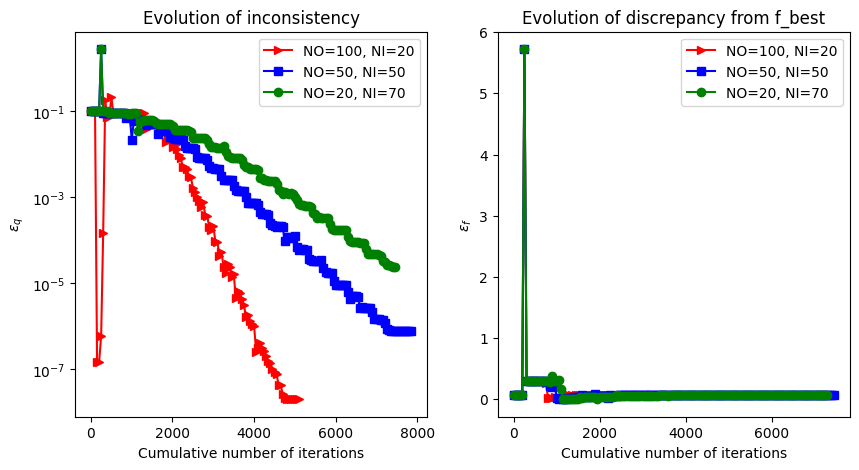

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=10, h=5)
ax1.set_title("Evolution of inconsistency")
ax1.set_ylabel(r'$\epsilon_{q}$')
ax1.set_xlabel("Cumulative number of iterations")
ax2.set_ylabel(r'$\epsilon_{f}$')
ax2.set_xlabel("Cumulative number of iterations")
ax2.set_title("Evolution of discrepancy from f_best")
ax1.set_yscale('log')


y2 = []
xy2 = []
f2 = []
xf2 = []
y1 = []
xy1 = []
f1 = []
xf1 = []
y3 = []
xy3 = []
f3 = []
xf3 = []
eps_qio = copy.deepcopy(MDAO.eps_qio)
eps_fio = copy.deepcopy(MDAO.eps_fio)
if MDAO.Coordinator.save_q_in_out:
  for i in range(1,len(eps_qio),50):
    y1.append(copy.deepcopy(eps_qio[i]))
    xy1.append(i+1)
  for i in range(1,len(eps_fio),50):
    f1.append(copy.deepcopy(eps_fio[i]))
    xf1.append(i+1)
  # ax1.set_xlim([1, len(eps_qio)])
  # ax2.set_xlim([1, len(eps_fio)])
else:
  y2 = copy.deepcopy(MDAO.Coordinator.eps_qo)
  f2 = copy.deepcopy(MDAO.Coordinator.eps_fo)
  ax1.plot(y2)
  ax2.plot(f2)

if MDAO2.Coordinator.save_q_in_out:
  for i in range(1,len(MDAO2.eps_qio), 50):
    y2.append(copy.deepcopy(MDAO2.eps_qio[i]))
    xy2.append(i+1)
  for i in range(1,len(MDAO2.eps_fio), 50):
    f2.append(copy.deepcopy(MDAO2.eps_fio[i]))
    xf2.append(i+1)
  # ax1.set_xlim([1, len(eps_qio)])
  # ax2.set_xlim([1, len(eps_fio)])
else:
  y2 = copy.deepcopy(MDAO2.Coordinator.eps_qo)
  f2 = copy.deepcopy(MDAO2.Coordinator.eps_fo)
  ax1.plot(y2)
  ax2.plot(f2)

if MDAO3.Coordinator.save_q_in_out:
  for i in range(1,len(MDAO3.eps_qio), 50):
    y3.append(copy.deepcopy(MDAO3.eps_qio[i]))
    xy3.append(i+1)
  for i in range(1,len(MDAO3.eps_fio), 50):
    f3.append(copy.deepcopy(MDAO3.eps_fio[i]))
    xf3.append(i+1)
  # ax1.set_xlim([1, len(eps_qio)])
  # ax2.set_xlim([1, len(eps_fio)])
else:
  y3 = copy.deepcopy(MDAO3.Coordinator.eps_qo)
  f3 = copy.deepcopy(MDAO3.Coordinator.eps_fo)
  ax1.plot(y3)
  ax2.plot(f3)

ax1.plot(xy1, y1, '->r',xy2, y2, '-sb', xy3, y3, '-og')
ax1.legend(['NO=100, NI=20', 'NO=50, NI=50', 'NO=20, NI=70'])
ax2.plot(xf1,  f1, '->r', xf2, f2,'-sb', xf3, f3, '-og')
ax2.legend(['NO=100, NI=20', 'NO=50, NI=50', 'NO=20, NI=70'])

plt.show()

# Sellar problem

<figure>
  <center><p><img src="https://github.com/Ahmed-Bayoumy/MDO_McGill/blob/DEV/Figures/sellar_xdsm.png?raw=true"
    width="600" height="300" align="middle">
  <figcaption>Fig.9 The XDSM of the MDF architecture of a Sellar MDO problem.</figcaption>
</figure>

<figure>
  <center><p><img src="https://github.com/Ahmed-Bayoumy/MDO_McGill/blob/DEV/Figures/Sellar_Wflow.png?raw=true"
    width="600" height="300" align="middle">
  <figcaption>Fig.10 The all-in-one MDO workflow.</figcaption>
</figure>

Original problem $\mathcal{P}$:

\begin{align*}
\text{min}: & \ \ \ x^2 + z_2 + y_1 + e^{-y_2} \\
\text{w.r.t.}: & \ \ \ x, z_1, z_2 \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ 3.16 - y_1 <=0 \\
& \ \ \ y_2 - 24.0 <=0 \\
& \ \ \ y_1 (x, z_{1}, z_{2}, y_{2}) = x+z^{2}_{1}+z_{2}-0.2y_{2} \\
& \ \ \ y_2 (z_{1}, z_{2}, y_{1}) = \sqrt{y_{1}}+z_{1}+z_{2} 
\tag{$\mathcal{P}$}
\end{align*}



<figure>
  <center><p><img src="https://github.com/Ahmed-Bayoumy/MDO_McGill/blob/DEV/Figures/Sellar_decomposed.png?raw=true"
    width="600" height="300" align="middle">
  <figcaption>Fig.11 The decomposed Sellar workflow.</figcaption>
</figure>

Subproblem $\mathcal{p}_{1}$:

\begin{align*}
\text{min}: & \ \ \ x^2 + z_2 + y_1 + e^{-y_2} + \phi_{z_{1}} (z_{1_{1}}-z_{1_{2}}) + \phi_{z_{2}} (z_{2_{1}}-z_{2_{2}}) + \phi_{y_{1}} (y_{1_{1}}-y_{1_{2}}) + \phi_{y_{2}} (y_{2_{1}}-y_{2_{2}})\\
\text{w.r.t.}: & \ \ \ x, z_{1_{1}}, z_{2_{1}}, y_{2_{1}} \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ 3.16 - y_{1_{1}} <=0 \\
& \ \ \ y_{1_{1}} (x, z_{1_{1}}, z_{2_{1}}, y_{2_{1}}) = x+z^{2}_{1_{1}}+z_{2_{1}}-0.2y_{2_{1}}
\tag{$\mathcal{p}_{1}$}
\end{align*}



Subproblem $\mathcal{p}_{2}$:

\begin{align*}
\text{min}: & \ \ \ \phi_{z_{1}} (z_{1_{1}}-z_{1_{2}}) + \phi_{z_{2}} (z_{2_{1}}-z_{2_{2}}) + \phi_{y_{1}} (y_{1_{1}}-y_{1_{2}}) + \phi_{y_{2}} (y_{2_{1}}-y_{2_{2}}) \\
\text{w.r.t.}: & \ \ \ x, z_{1_{2}}, z_{2_{2}}, y_{1_{2}} \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ y_{2_{2}} - 24.0 <=0 \\
& \ \ \ y_{2_{2}} (z_{1_{2}}, z_{2_{2}}, y_{1_{2}}) = \sqrt{y_{1_{2}}}+z_{1_{2}}+z_{2_{2}} 
\tag{$\mathcal{p}_{2}$}
\end{align*}




In [83]:
#  Sellar - Two discipline problem with IDF

#  Variables grouping and problem setup
x = {}
X: List[variableData] = []
# Define variable names
N = ["x", "z1", "z2", "y1", "y2", "z1", "z2", "y1", "y2"]
nx: int = len(N)
# Subproblem indices: Indices should be non-zero
J = [1,1,1,1,1,2,2,2,2]
# Subproblems links
L = [None, 2, 2, 2, 2, 1, 1, 1, 1]
# Coupling types
Ct = [COUPLING_TYPE.UNCOUPLED, 
      COUPLING_TYPE.SHARED, 
      COUPLING_TYPE.SHARED,
      COUPLING_TYPE.FEEDFORWARD, 
      COUPLING_TYPE.FEEDBACK, 
      COUPLING_TYPE.SHARED,
      COUPLING_TYPE.SHARED, 
      COUPLING_TYPE.FEEDBACK,
      COUPLING_TYPE.FEEDFORWARD]
# Realistic lower bounds
lb = [0, -10, 0, 3.16, 1.77763888346, -10, 0, 3.16, 1.77763888346]
# Realistic upper bounds
ub = [10.,10.,10., 115.2, 24., 10.,10., 115.2, 24.]

# # Artificial lower bounds
# lb = [0, -10, 0, 2., 1.5, -10, 0, 2., 1.5]
# # Artificial upper bounds
# ub = [10.,10.,10., 50., 50, 10.,10., 50., 50]

# Bad artificial lower bounds
# lb = [0, -10, 0, 0., 0., -10, 0, 0., 0.]
# Bad artificial upper bounds
# ub = [10.]*9

# Baseline
x0 = [0., 5., 5., 8.43, 7.848, 5., 5., 8.43, 7.848]
# Scaling
scaling = np.subtract(ub,lb)
Qscaling = []
# Create a dictionary for each variable
for i in range(nx):
  x[f"var{i+1}"] = {"index": i+1,
  "sp_index": J[i],
  f"name": N[i],
  "dim": 1,
  "value": 0.,
  "coupling_type": Ct[i],
  "link": L[i],
  "baseline": x0[i],
  "scaling": scaling[i],
  "lb": lb[i],
  "value": x0[i],
  "ub": ub[i]}
  Qscaling.append(10./scaling[i] if 10./scaling[i] != np.inf and 10./scaling[i] != np.nan else 1.)

# Instantiate the variableData class for each variable using its according dictionary
for i in range(nx):
  X.append(variableData(**x[f"var{i+1}"]))


def Sellar_A1(x):
  return x[0] + x[1]**2 + x[2] - 0.2*x[3]

def Sellar_A2(x):
  return x[0] + x[1] + np.sqrt(x[2]) 


def Sellar_opt1(x, y):
  return [x[0]**2 + x[2] + y[0] + np.exp(-x[3]), [3.16-y[0]]]

def Sellar_opt2(x, y):
  return [0., [y[0]-24.]]

# Analyses setup; construct disciplinary analyses
DA1: process = DA(inputs=[X[0], X[1], X[2], X[4]],
outputs=[X[3]],
blackbox=Sellar_A1,
links=2,
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

DA2: process = DA(inputs=[X[5], X[6], X[7]],
outputs=[X[8]],
blackbox=Sellar_A2,
links=1,
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

sp1_MDA: process = MDA(nAnalyses=1, analyses = [DA1], variables=[X[0], X[1], X[2], X[4]], responses=[X[3]])
sp2_MDA: process = MDA(nAnalyses=1, analyses = [DA2], variables=[X[5], X[6], X[7]], responses=[X[8]])


 # Construct the coordinator
coord = ADMM(beta = 1.3,
nsp=2,
budget = 500,
index_of_master_SP=1,
display = True,
scaling = Qscaling,
mode = "serial",
M_update_scheme= w_scheme.MAX,
store_q_io=True
)

# Construct subproblems
sp1 = SubProblem(nv = 4,
index = 1,
vars = [X[0], X[1], X[2], X[4]],
resps = [X[3]],
is_main=1,
analysis= sp1_MDA,
coordination=coord,
opt=Sellar_opt1,
fmin_nop=np.inf,
budget=10,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST,
freal=6.57,
solver="OMADS")

sp2 = SubProblem(nv = 3,
index = 2,
vars = [X[5], X[6], X[7]],
resps = [X[8]],
is_main=0,
analysis= sp2_MDA,
coordination=coord,
opt=Sellar_opt2,
fmin_nop=np.inf,
budget=10,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST,
solver="scipy"
)

MDAO: MDO = MDO(
Architecture = MDO_ARCHITECTURE.IDF,
Coordinator = coord,
subProblems = [sp1, sp2],
variables = X,
responses = [X[3], X[8]],
fmin = np.inf,
hmin = np.inf,
display = True,
inc_stop = 1E-9,
stop = "Iteration budget exhausted",
tab_inc = [],
noprogress_stop = 100
)

# Run the MDO problem
out = MDAO.run()

# Print summary output

print(f'------Run_Summary------')
print(MDAO.stop)
print(f'q = {MDAO.Coordinator.q}')
for i in MDAO.Coordinator.master_vars:
  print(f'{i.name}_{i.sp_index} = {i.value}')

fmin = 0
hmax = -np.inf
for j in range(len(MDAO.subProblems)):
  print(f'SP_{MDAO.subProblems[j].index}: fmin= {MDAO.subProblems[j].MDA_process.getOutputs()}, hmin= {MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , MDAO.subProblems[j].MDA_process.getOutputs())[1]}')
  fmin += sum(MDAO.subProblems[j].MDA_process.getOutputs())
  hmin= MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , MDAO.subProblems[j].MDA_process.getOutputs())[1]
  if max(hmin) > hmax: 
    hmax = max(hmin) 
print(f'P_main: fmin= {fmin}, hmax= {hmax}')
print(f'Final obj value of the main problem: \n {fmin}')

0 || qmax: 0.22014503039662145 || Obj: 7.330636869784574 || dx: 8.007835593079866 || max(w): 1.0
Highest inconsistency : y2_2 to y2_1
1 || qmax: 0.2077442871553388 || Obj: 6.980901453337879 || dx: 9.066101832777022 || max(w): 2.8561000000000005
Highest inconsistency : y2_2 to y2_1
2 || qmax: 0.20327510604285037 || Obj: 6.831226756784423 || dx: 9.168135435077142 || max(w): 2.8561000000000005
Highest inconsistency : y2_2 to y2_1
3 || qmax: 0.19901282864155778 || Obj: 6.634522259042286 || dx: 9.08621654047695 || max(w): 2.8561000000000005
Highest inconsistency : y2_2 to y2_1
4 || qmax: 0.012533887281041236 || Obj: 6.959976003344675 || dx: 9.273770354820421 || max(w): 2.8561000000000005
Highest inconsistency : y2_2 to y2_1
5 || qmax: 0.023219429332065833 || Obj: 6.873669375174262 || dx: 9.597642933707847 || max(w): 8.157307210000003
Highest inconsistency : z1_2 to z1_1
6 || qmax: 0.026012129275586937 || Obj: 6.6150324659260855 || dx: 9.787186507563923 || max(w): 8.157307210000003
Highest i

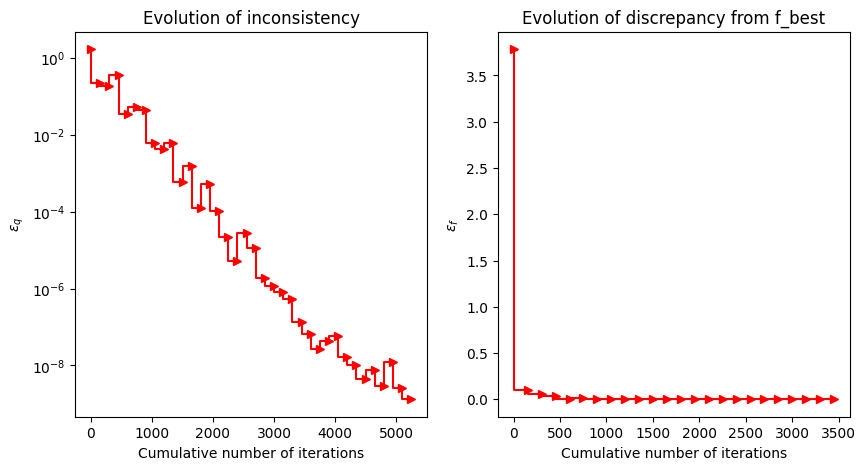

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(w=10, h=5)
ax1.set_title("Evolution of inconsistency")
ax1.set_ylabel(r'$\epsilon_{q}$')
ax1.set_xlabel("Cumulative number of iterations")
ax2.set_ylabel(r'$\epsilon_{f}$')
ax2.set_xlabel("Cumulative number of iterations")
ax2.set_title("Evolution of discrepancy from f_best")
ax1.set_yscale('log')


y2 = []
xy2 = []
f2 = []
xf2 = []
y1 = []
xy1 = []
f1 = []
xf1 = []
eps_qio = copy.deepcopy(MDAO.eps_qio)
eps_fio = copy.deepcopy(MDAO.eps_fio)
if MDAO.Coordinator.save_q_in_out:
  for i in range(1,len(eps_qio),150):
    y1.append(copy.deepcopy(eps_qio[i]))
    xy1.append(i+1)
  for i in range(1,len(eps_fio),150):
    f1.append(copy.deepcopy(eps_fio[i]))
    xf1.append(i+1)
  # ax1.set_xlim([1, len(eps_qio)])
  # ax2.set_xlim([1, len(eps_fio)])
else:
  y2 = copy.deepcopy(MDAO.Coordinator.eps_qo)
  f2 = copy.deepcopy(MDAO.Coordinator.eps_fo)
  ax1.plot(y2)
  ax2.plot(f2)



ax1.step(xy1, y1, '->r')
ax2.step(xf1,  f1, '->r')

# Speed reducer


Original problem $\mathcal{P}$:

\begin{align*}
\text{min}: & \ \ \ 0.7854x_{1}x^{2}_{2}(3.3333x^{2}_{3} + 14.9334x_{3} -43.0934) -1.5079x_{1}(x^{2}_{6} + x^{2}_{7}) +7.477(x^{3}_{6}+x^{3}_{7}) + 0.7854(x_{4}x^{2}_{6}+x_{5}x^{2}_{7}) \\
\text{w.r.t.}: & \ \ \ x_{1}, x_{2}, x_{3}, x_4, x_5, x_6, x_7 \\
\text{s.t. }: \ \ \ \\
& \ \ \ 27x^{-1}_{1}x^{-2}_{2}x^{-1}_{3} \leq 1 \\
& \ \ \ 397.5x^{-1}_{1}x^{-2}_{2}x^{-2}_{3} \leq 1 \\
& \ \ \ 1.93x^{-1}_{2}x^{-1}_{3}x^{3}_{4}x^{-4}_{6} \leq 1 \\
& \ \ \ 1.93x^{-1}_{2}x^{-1}_{3}x^{3}_{5}x^{-4}_{7} \leq 1 \\
& \ \ \ [(745x_{4}x^{-1}_{2}x^{-1}_{3})^{2} + 16.9 \times 10^{6}]^{0.5} / [ 110.0x^{3}_{6} ] \leq 1 \\
& \ \ \ [(745x_{5}x^{-1}_{2}x^{-1}_{3})^{2} + 157.5 \times 10^{6}]^{0.5} / [ 85.0x^{3}_{7} ] \leq 1 \\
& \ \ \ x_{2}x_{3}/40 \leq 1 \\
& \ \ \ 5x_{2}/x_1 \leq 1 \\
& \ \ \ x_{1}/12x_2 \leq 1 \\
& \ \ \ (1.5x_6 + 1.9)x^{-1}_4 \leq 1 \\
& \ \ \ (1.1x_7 + 1.9)x^{-1}_5 \leq 1 \\
& \ \ \ 2.6 \leq x_1 \leq 3.6\\
& \ \ \ 0.7 \leq x_2 \leq 0.8\\
& \ \ \ 17 \leq x_3 \leq 28\\
& \ \ \ 7.3 \leq x_4 \leq 8.3\\
& \ \ \ 7.3 \leq x_5 \leq 8.3\\
& \ \ \ 2.9 \leq x_6 \leq 3.9\\
& \ \ \ 5.0 \leq x_7 \leq 5.5\\
\tag{$\mathcal{P}$}
\end{align*}



<figure>
  <center><p><img src="Figures/SR_flowD.png"
    width="400" height="250" align="middle">
  <figcaption>Fig.12 The XDSM of the MDF architecture of a Sellar MDO problem.</figcaption>
</figure>


Subproblem $\mathcal{p}_{1}$:

\begin{align*}
\text{min}: & \ \ \ 0.7854x_{1_{1}}x^{2}_{2_{1}}(3.3333x^{2}_{3_{1}} + 14.9334x_{3_{1}} -43.0934) + \phi_{x_{1_{12}}} (x_{1_{1}}-x_{1_{2}}) + \phi_{x_{1_{13}}} (x_{1_{1}}-x_{1_{3}}) + \phi_{x_{2_{12}}} (x_{2_{1}}-x_{2_{2}}) + \phi_{x_{2_{13}}} (x_{2_{1}}-x_{2_{3}}) + \phi_{x_{3_{12}}} (x_{3_{1}}-x_{3_{2}}) + \phi_{x_{3_{13}}} (x_{3_{1}}-x_{3_{3}})\\
\text{w.r.t.}: & \ \ \ x_{1_{1}}, x_{2_{1}}, x_{3_{1}} \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ 27x^{-1}_{1_{1}}x^{-2}_{2_{1}}x^{-1}_{3_{1}} \leq 1 \\
& \ \ \ 397.5x^{-1}_{1_{1}}x^{-2}_{2_{1}}x^{-2}_{3_{1}} \leq 1 \\
& \ \ \ x_{2_{1}}x_{3_{1}}/40 \leq 1 \\
& \ \ \ 5x_{2_{1}}/x_{1_{1}} \leq 1 \\
& \ \ \ x_{1_{1}}/12x_{2_{1}} \leq 1
\end{align*}
\tag{$\mathcal{p}_{1}$}
\end{equation}

Subproblem $\mathcal{p}_{2}$:
\begin{equation}
\begin{align*}
\text{min}: & \ \ \ -1.5079x_{1_{2}}(x^{2}_{6} + x^{2}_{7}) +7.477(x^{3}_{6}+x^{3}_{7}) + \phi_{x_{1_{12}}} (x_{1_{1}}-x_{1_{2}}) + \phi_{x_{1_{13}}} (x_{1_{1}}-x_{1_{3}}) + \phi_{x_{2_{12}}} (x_{2_{1}}-x_{2_{2}}) + \phi_{x_{2_{13}}} (x_{2_{1}}-x_{2_{3}}) + \phi_{x_{3_{12}}} (x_{3_{1}}-x_{3_{2}}) + \phi_{x_{3_{13}}} (x_{3_{1}}-x_{3_{3}})\\
\text{w.r.t.}: & \ \ \ x_{1_{1}}, x_{2_{1}}, x_{3_{1}}, x_4, x_6 \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ 1.93x^{-1}_{2_{2}}x^{-1}_{3_{2}}x^{3}_{4_{2}}x^{-4}_{6} \leq 1 \\
& \ \ \ (1.5x_6 + 1.9)x^{-1}_{4_{2}} \leq 1 \\
& \ \ \ [(745x_{4}x^{-1}_{2_{2}}x^{-1}_{3_{2}})^{2} + 16.9 \times 10^{6}]^{0.5} / [ 110.0x^{3}_{6} ] \leq 1
\tag{$\mathcal{p}_{2}$}
\end{align*}



Subproblem $\mathcal{p}_{3}$:

\begin{align*}
\text{min}: & \ \ \ 0.7854(x_{4_{3}}x^{2}_{6}+x_{5}x^{2}_{7}) + \phi_{x_{1_{12}}} (x_{1_{1}}-x_{1_{2}}) + \phi_{x_{1_{13}}} (x_{1_{1}}-x_{1_{3}}) + \phi_{x_{2_{12}}} (x_{2_{1}}-x_{2_{2}}) + \phi_{x_{2_{13}}} (x_{2_{1}}-x_{2_{3}}) + \phi_{x_{3_{12}}} (x_{3_{1}}-x_{3_{2}}) + \phi_{x_{3_{13}}} (x_{3_{1}}-x_{3_{3}})\\
\text{w.r.t.}: & \ \ \ x_{1_{3}}, x_{2_{3}}, x_{3_{3}}, x_{5}, x_{7} \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ [(745x_{5}x^{-1}_{2_{3}}x^{-1}_{3_{3}})^{2} + 157.5 \times 10^{6}]^{0.5} / [ 85.0x^{3}_{7} ] \leq 1 \\
& \ \ \ (1.1x_7 + 1.9)x^{-1}_5 \leq 1 \\
& \ \ \ 1.93x^{-1}_{2_{3}}x^{-1}_{3_{3}}x^{3}_{5}x^{-4}_{7} \leq 1
\tag{$\mathcal{p}_{3}$}
\end{align*}



In [93]:
def SR_A1(x):
  """ Speed reducer A1 """
  return [(0.7854*x[0]*x[1]**2*(3.3333*x[2]*x[2] + 14.9335*x[2] - 43.0934))]

def SR_A2(x):
  """ Speed reducer A2 """
  return [(-1.5079*x[0]*x[4]**2) + (7.477 * x[4]**3)]

def SR_A3(x):
  """ Speed reducer A3 """
  return [0.7854 * x[3] * x[4]**2]


def SR_opt1(x, y):
  g5 = 27/(x[0]*x[1]**2*x[2]) -1
  g6 = 397.5/(x[0]*x[1]**2*x[2]**2) -1
  g9 = x[1]*x[2]/40 -1
  g10 = 5*x[1]/x[0] -1
  g11 = x[0]/(12*x[1]) -1
  return [y[0], [g5,g6,g9,g10,g11]]


def SR_opt2(x, y):
  g1 = np.sqrt( ((745*x[3])/(x[1]*x[2]))**2 + 1.69e+7)/(110*x[4]**3) -1
  g3 = (1.5*x[4] + 1.9)/x[3] -1
  g7 = 1.93*x[3]**3/(x[1]*x[2]*x[4]**4) -1
  return [y[0], [g1,g3,g7]]

def SR_opt3(x, y):
  g2 = np.sqrt( ((745*x[3])/(x[1]*x[2]))**2 + 1.575e+8)/(85*x[4]**3) -1
  g4 = (1.1*x[4] + 1.9)/x[3] -1
  g8 = (1.93*x[3]**3)/(x[1]*x[2]*x[4]**4) -1
  return [y[0], [g2, g4, g8]]
#  Variables setup
f1min = 722
f1max = 5408
f2min = 184
f2max = 506
f3min = 942
f3max = 1369
#
v = {}
V: List[variableData] = []
s  = COUPLING_TYPE.SHARED
ff = COUPLING_TYPE.FEEDFORWARD
fb = COUPLING_TYPE.FEEDBACK
un = COUPLING_TYPE.UNCOUPLED
dum = COUPLING_TYPE.DUMMY


names = ["x1", "x2", "x3", "f1",   "x1", "x2", "x3", "x4", "x6", "f2",   "x1", "x2", "x3", "x5", "x7", "f3"]
spi =   [   1,    1,    1,		1,		  2,		2,		2,		2,		2,		2,      3,    3,		3,		3,    3,	  3]
links = [[2,3],[2,3],[2,3],   None,  [1,3],[1,3],[1,3], None, None,    None,  [1,2],[1,2],[1,2], None, None,    None]
lb =    [2.6 ,  0.7 ,  17., 722.,  2.6 ,  0.7,  17.,  7.3,  2.9, 184.,   2.6 ,  0.7,  17.,  7.3,   5.,942.]
ub =    [3.6 ,  0.8 ,  28.,5408.,  3.6 ,  0.8,  28.,  8.3,  3.9, 506.,   3.6 ,  0.8 , 28.,  8.3,  5.5,1369.]
bl =    np.divide(np.subtract(ub, lb), 2.)

coupling_t = \
        [ s,      s,		s,		un,		s,		s,		s,		un,		un,	 un,   s,    s,    s,   un,    un,    un]

scaling = [10.] * 16

# Variables dictionary with subproblems link
for i in range(16):
  v[f"var{i+1}"] = {"index": i+1,
  "sp_index": spi[i],
  f"name": names[i],
  "dim": 1,
  "value": 0.,
  "coupling_type": coupling_t[i],
  "link": links[i],
  "baseline": bl[i],
  "scaling": scaling[i],
  "lb": lb[i],
  "value": bl[i],
  "ub": ub[i]}

for i in range(16):
  V.append(variableData(**v[f"var{i+1}"]))

# Analyses setup; construct disciplinary analyses
DA1: process = DA(inputs=[V[0], V[1], V[2]],
outputs=[V[3]],
blackbox=SR_A1,
links=[4],
coupling_type=COUPLING_TYPE.FEEDFORWARD)

DA2: process = DA(inputs=[V[4], V[5], V[6], V[7], V[8]],
outputs=[V[9]],
blackbox=SR_A2,
links=[4],
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

DA3: process = DA(inputs=[V[10], V[11], V[12], V[13], V[14]],
outputs=[V[15]],
blackbox=SR_A3,
links=[4],
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

# MDA setup; construct subproblems MDA
sp1_MDA: process = MDA(nAnalyses=1, analyses = [DA1], variables=[V[0], V[1], V[2]], responses=[V[3]])
sp2_MDA: process = MDA(nAnalyses=1, analyses = [DA2], variables=[V[4], V[5], V[6], V[7], V[8]], responses=[V[9]])
sp3_MDA: process = MDA(nAnalyses=1, analyses = [DA3], variables=[V[10], V[11], V[12], V[13], V[14]], responses=[V[15]])

# Construct the coordinator
coord = ADMM(beta = 1.3,
nsp=4,
budget = 50,
index_of_master_SP=1,
display = True,
scaling = 0.1,
mode = "serial",
M_update_scheme= w_scheme.MEDIAN
)

# Construct subproblems
sp1 = SubProblem(nv = 3,
index = 1,
vars = [V[0], V[1], V[2]],
resps = [V[3]],
is_main=1,
analysis= sp1_MDA,
coordination=coord,
opt=SR_opt1,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST)

sp2 = SubProblem(nv = 5,
index = 2,
vars = [V[4], V[5], V[6], V[7], V[8]],
resps = [V[9]],
is_main=0,
analysis= sp2_MDA,
coordination=coord,
opt=SR_opt2,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST
)

sp3 = SubProblem(nv = 5,
index = 3,
vars = [V[10], V[11], V[12], V[13], V[14]],
resps = [V[15]],
is_main=0,
analysis= sp3_MDA,
coordination=coord,
opt=SR_opt3,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST)

# Construct MDO workflow
MDAO: MDO = MDO(
Architecture = MDO_ARCHITECTURE.IDF,
Coordinator = coord,
subProblems = [sp1, sp2, sp3],
variables = V,
responses = [V[3], V[9], V[15]],
fmin = np.inf,
hmin = np.inf,
display = False,
inc_stop = 1E-9,
stop = "Iteration budget exhausted",
tab_inc = [],
noprogress_stop = 100
)


# Run the MDO problem
out = MDAO.run()

print(f'------Run_Summary------')
print(MDAO.stop)
print(f'q = {MDAO.Coordinator.q}')
for i in MDAO.Coordinator.master_vars:
  print(f'{i.name}_{i.sp_index} = {i.value}')
fmin = 0
hmax = -np.inf
for j in range(len(MDAO.subProblems)):
  print(f'SP_{MDAO.subProblems[j].index}: fmin= {MDAO.subProblems[j].MDA_process.getOutputs()}, hmin= {MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , MDAO.subProblems[j].MDA_process.getOutputs())[1]}')
  fmin += sum(MDAO.subProblems[j].MDA_process.getOutputs())
  hmin= MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , MDAO.subProblems[j].MDA_process.getOutputs())[1]
  if max(hmin) > hmax: 
    hmax = max(hmin) 
print(f'P_main: fmin= {fmin}, hmax= {hmax}')
print(f'Final obj value of the main problem: \n {fmin}')


Stop: qmax = 4.4408920985006264e-17 < 1e-09
------Run_Summary------
Max inconsitency is below stopping threshold
q = [-4.4408921e-17  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
x1_1 = 3.5
x2_1 = 0.7
x3_1 = 17.0
f1_1 = 2343.0
x1_2 = 3.5000000000000004
x2_2 = 0.7
x3_2 = 17.0
x4_2 = 7.3
x6_2 = 3.5
f2_2 = 161.0
x1_3 = 3.5
x2_3 = 0.7
x3_3 = 17.0
x5_3 = 8.100000000000001
x7_3 = 5.3
f3_3 = 213.5
SP_1: fmin= [2343.0], hmin= [-0.07391528039787332, -0.1979985271419491, -0.7025, 0.0, -0.5833333333333333]
SP_2: fmin= [161.0], hmin= [-0.1229713648062638, -0.020547945205479423, -0.5795573637034989]
SP_3: fmin= [213.5], hmin= [-0.007460057148634958, -0.04567901234567917, -0.8907649716200587]
P_main: fmin= 2717.5, hmax= 0.0
Final obj value of the main problem: 
 2717.5


# Geometric programming

Original problem $\mathcal{P}$:

\begin{align*}
\text{min}: & \ \ \ z^{2}_1 + z^{2}_2 \\
\text{w.r.t.}: & \ \ \ z_{1}, z_{2}, z_{3}, z_4, z_5, z_6, z_7, z_8, z_9, z_{10}, z_{11}, z_{12}, z_{13}, z_{14} \\
\text{s.t. }: \ \ \ & z_{i} \in [10^{-6}, 10^6 ] \ \ \forall i \\
& \ \ \ z^{2}_1 = z^{2}_{3} + z^{-2}_{4} + z^{2}_{5} \\
& \ \ \ z^{2}_2 = z^{2}_{5} + z^{2}_{6} + z^{2}_{7} \\
& \ \ \ z^{2}_3 = z^{2}_{8} + z^{-2}_{9} + z^{-2}_{10} + z^{2}_{11}\\
& \ \ \ z^{2}_6 = z^{2}_{11} + z^{2}_{12} + z^{2}_{13} + z^{2}_{14} \\
& \ \ \ z^{-2}_3 + z^{2}_{4} - z^{2}_{5} \leq 0 \\
& \ \ \ z^{2}_5 + z^{-2}_{6} - z^{2}_{7} \leq 0 \\
& \ \ \ z^{2}_8 + z^{2}_{9} - z^{2}_{11} \leq 0 \\
& \ \ \ z^{-2}_8 + z^{2}_{10} - z^{2}_{11} \leq 0 \\
& \ \ \ z^{2}_{11} + z^{-2}_{12} - z^{2}_{13} \leq 0 \\
& \ \ \ z^{2}_{11} + z^{2}_{12} - z^{2}_{14} \leq 0
\tag{$\mathcal{P}$}
\end{align*}



<figure>
  <center><p><img src="Figures/GP_flowD.png"
    width="400" height="250" align="middle">
  <figcaption>Fig.12 The XDSM of the MDF architecture of a Sellar MDO problem.</figcaption>
</figure>

Subproblem $\mathcal{p}_{1}$:

\begin{align*}
\text{min}: & \ \ \ t^{2}_{y_{21}} + t^{2}_{y_{31}} + z^{-2}_4 + 2z^{2}_{5}+ z^{2}_{7} + \phi_{y_{21}} (t_{y_{21}}-r_{y_{21}}) + \phi_{y_{31}} (t_{y_{31}}-r_{y_{31}})\\
\text{w.r.t.}: & \ \ \ t_{y_{21}}, t_{y_{31}}, z_{4}, z_{5}, z_{7} \in [10^{-6}; 10^{6}] \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ t^{-2}_{y_{21}}+z^{2}_{4}-z^{2}_{5} \leq 0 \\
& \ \ \ z^{2}_{5} + t^{-2}_{y_{31}} - z^{2}_{7} \leq 0
\end{align*}
\tag{$\mathcal{p}_{1}$}
\end{equation}

Subproblem $\mathcal{p}_{2}$:
\begin{equation}
\begin{align*}
\text{min}: & \ \ \ \phi_{y_{21}} (t_{y_{21}}-r_{y_{21}}) + \phi_{s_{23}} (t_{s_{23}}-r_{s_{23}})\\
\text{w.r.t.}: & \ \ \ z_8, z_9, z_{10}, t_{s_{23}}  \in [10^{-6}; 10^{6}] \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ z^{2}_8 + z^{2}_{9} - t^{2}_{s_{23}} \leq 0 \\
& \ \ \ z^{-2}_8 + z^{2}_{10} - t^{2}_{s_{23}} \leq 0 \\
\text{where} & \ \ \ r_{y_{21}} = \sqrt{z^{2}_{8}+z^{-2}_{9}+z^{-2}_{10}+t^{2}_{s_{23}}}
\tag{$\mathcal{p}_{2}$}
\end{align*}




Subproblem $\mathcal{p}_{3}$:

\begin{align*}
\text{min}: & \ \ \ \phi_{y_{31}} (t_{y_{31}}-r_{y_{31}}) + \phi_{s_{23}} (t_{s_{23}}-r_{s_{23}})\\
\text{w.r.t.}: & \ \ \ z_{12}, z_{13}, z_{14}, r_{s_{23}}  \in [10^{-6}; 10^{6}] \\
\text{s.t. }: & \ \ \ & \\
& \ \ \ r^{2}_{s_{23}} + z^{-2}_{12} - z^{2}_{13} \leq 0 \\
& \ \ \ r^{2}_{s_{23}} + z^{2}_{12} - z^{2}_{14} \leq 0 \\
\text{where} & \ \ \ r_{y_{31}} = \sqrt{r^{2}_{s_{23}} + z^{2}_{12} +z^{2}_{13} + z^{2}_{14}}
\tag{$\mathcal{p}_{3}$}
\end{align*}




In [94]:
def GP_A1(z):
  z1 = np.sqrt(z[0]**2 + z[1]**-2 + z[2]**2)
  z2 = np.sqrt(z[2]**2 + z[3]**2  + z[4]**2)
  return z1**2 + z2**2

def GP_opt1(z,y):
  if isinstance(y, list) and len(y) > 0:
    return [y[0], [z[0]**-2 + z[1]**2 - z[2]**2, z[2]**2 + z[3]**-2  - z[4]**2]]
  else:
    return [y, [z[0]**-2 + z[1]**2 - z[2]**2, z[2]**2 + z[3]**-2  - z[4]**2]]

def GP_A2(z):
  z3 = np.sqrt(z[0]**2 + z[1]**-2 + z[2]**-2 + z[3]**2)
  return z3

def GP_opt2(z,y):
  return [0, [z[0]**2 + z[1]**2 - z[3]**2, z[0]**-2 + z[2]**2 - z[3]**2]]

def GP_A3(z):
  z6 = np.sqrt(z[0]**2 + z[1]**2 + z[2]**2 +z[3] **2)
  return z6

def GP_opt3(z, y):
  return [0, [z[0]**2 + z[1]**-2 - z[2]**2, z[0]**2 +z[1]**2 - z[3]**2]]

v = {}
V: List[variableData] = []
s  = COUPLING_TYPE.SHARED
ff = COUPLING_TYPE.FEEDFORWARD
fb = COUPLING_TYPE.FEEDBACK
un = COUPLING_TYPE.UNCOUPLED
dum = COUPLING_TYPE.DUMMY


names = ["z3", "z4", "z5", "z6",   "z7", "z3", "z8", "z9", "z10", "z11",   "z6", "z11", "z12", "z13", "z14", "dd"]
spi =   [   1,    1,    1,		1,		  1,		2,		2,		2,		2,		  2,      3,     3,		  3,		 3,     3, 1]
links = [   2, None, None,    3,   None,    1, None, None, None,      3,      1,     2,  None,  None,  None, None]
coupling_t = \
        [ fb,    un,	 un,	 fb,		 un,	 ff,	 un,	 un,	 un,	    s,     ff,     s,    un,    un,    un, ff]

lb =    [1e-6]*15
ub =    [1e6]*15
bl =    [1.]*15
scaling = [9.e5] * 15

lb.append(15)
ub.append(18)
bl.append(GP_A1([1]*5))
scaling.append(1)

# Variables dictionary with subproblems link
for i in range(16):
  v[f"var{i+1}"] = {"index": i+1,
  "sp_index": spi[i],
  f"name": names[i],
  "dim": 1,
  "coupling_type": coupling_t[i],
  "link": links[i],
  "baseline": bl[i],
  "scaling": scaling[i],
  "lb": lb[i],
  "value": bl[i],
  "ub": ub[i]}

for i in range(16):
  V.append(variableData(**v[f"var{i+1}"]))

# Analyses setup; construct disciplinary analyses
DA1: process = DA(inputs=[V[0], V[1], V[2], V[3], V[4]],
outputs=[V[15]],
blackbox=GP_A1,
links=[2, 3],
coupling_type=COUPLING_TYPE.FEEDBACK)

DA2: process = DA(inputs=[V[6], V[7], V[8], V[9]],
outputs=[V[5]],
blackbox=GP_A2,
links=[1, 3],
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

DA3: process = DA(inputs=[V[11], V[12], V[13], V[14]],
outputs=[V[10]],
blackbox=GP_A3,
links=[1, 2],
coupling_type=COUPLING_TYPE.FEEDFORWARD
)

# MDA setup; construct subproblems MDA
sp1_MDA: process = MDA(nAnalyses=1, analyses = [DA1], variables=[V[0], V[1], V[2], V[3], V[4]], responses=[V[15]])
sp2_MDA: process = MDA(nAnalyses=1, analyses = [DA2], variables=[V[6], V[7], V[8], V[9]], responses=[V[5]])
sp3_MDA: process = MDA(nAnalyses=1, analyses = [DA3], variables=[V[11], V[12], V[13], V[14]], responses=[V[10]])

# Construct the coordinator
coord = ADMM(beta = 1.3,
nsp=3,
budget = 200,
index_of_master_SP=1,
display = True,
scaling = 1.,
mode = "serial",
M_update_scheme= w_scheme.MEDIAN
)

# Construct subproblems
sp1 = SubProblem(nv = 5,
index = 1,
vars = [V[0], V[1], V[2], V[3], V[4]],
resps = [V[15]],
is_main=1,
analysis= sp1_MDA,
coordination=coord,
opt=GP_opt1,
fmin_nop=np.inf,
budget=5,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST,
freal=15.)

sp2 = SubProblem(nv = 4,
index = 2,
vars = [V[6], V[7], V[8], V[9]],
resps = [V[5]],
is_main=0,
analysis= sp2_MDA,
coordination=coord,
opt=GP_opt2,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST
)

sp3 = SubProblem(nv = 4,
index = 3,
vars = [V[11], V[12], V[13], V[14]],
resps = [V[10]],
is_main=0,
analysis= sp3_MDA,
coordination=coord,
opt=GP_opt3,
fmin_nop=np.inf,
budget=20,
display=False,
psize = 1.,
pupdate=PSIZE_UPDATE.LAST)

# Construct MDO workflow
MDAO: MDO = MDO(
Architecture = MDO_ARCHITECTURE.IDF,
Coordinator = coord,
subProblems = [sp1, sp2, sp3],
variables = V,
responses = [V[5], V[10], V[15]],
fmin = np.inf,
hmin = np.inf,
display = False,
inc_stop = 1E-9,
stop = "Iteration budget exhausted",
tab_inc = [],
noprogress_stop = 100
)


# Run the MDO problem
out = MDAO.run()
print(f'------Run_Summary------')
print(MDAO.stop)
print(f'q = {MDAO.Coordinator.q}')
xsp2 = []
xsp3 = []
index = np.argmax(MDAO.Coordinator.q)
for i in MDAO.Coordinator.master_vars:
  if i.sp_index == MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].link:
    xsp2.append(i.value)
  if i.sp_index == MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].link:
    xsp3.append(i.value)
  print(f'{i.name}_{i.sp_index} = {i.value}')
fmin = 0
hmax = -np.inf
for j in range(len(MDAO.subProblems)):
  print(f'SP_{MDAO.subProblems[j].index}: fmin= {MDAO.subProblems[j].MDA_process.getOutputs()}, hmin= {MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , [])[1]}')
  if MDAO.subProblems[j].is_main:
    fmin = MDAO.subProblems[j].MDA_process.getOutputs()
    hmin= MDAO.subProblems[j].opt([s.value for s in MDAO.subProblems[j].get_design_vars()] , [])[1]
    if max(hmin) > hmax: 
      hmax = max(hmin) 
print(f'P_main: fmin= {fmin}, hmax= {hmax}')
print(f'Final obj value of the main problem: \n {fmin}')

# Checking the impact of swapping z11_2 and z11_3 on the feasibility of SP2 and SP3, respectively

temp = copy.deepcopy(xsp3[1])
xsp3[1] = xsp2[-1]
xsp2[-1] = temp
print(f'For {MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].name}_'
  f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].link} to '
    f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].name}_'
  f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].link}, using {MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].name}_'
  f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].link}' 
  f' will make h_sp{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].link} = {GP_opt2(xsp2, 0)[1]}')
print(f'For {MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].name}_'
  f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].link} to '
    f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].name}_'
  f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].link}, using {MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].name}_'
  f'{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[1,index]-1].link}' 
  f' will make h_sp{MDAO.Coordinator.master_vars[MDAO.Coordinator._linker[0,index]-1].link} = {GP_opt3(xsp3, 0)[1]}')

------Run_Summary------
Iteration budget exhausted
q = [2.88441107e-06 4.45043309e-06 8.48165453e-01]
z3_1 = 2.4322916666652348
z4_1 = 0.8263888888890625
z5_1 = 1.1067718333322265
z6_1 = 1.8810763888880082
z7_1 = 1.2772304746190208
z3_2 = 2.432288782254166
z8_2 = 0.9932815540250562
z9_2 = 0.7868401886315693
z10_2 = 0.7650564275750565
z11_2 = 1.2671723230845808
z6_3 = 1.8810719384549137
z11_3 = 0.4190068704465811
z12_3 = 1.0057824680485508
z13_3 = 1.078935277359736
z14_3 = 1.0895710965310725
dd_1 = 14.999999968377349
SP_1: fmin= [14.999999968377349], hmin= [-0.37299338638679624, -0.12376404771258809]
SP_2: fmin= [2.432288782254166], hmin= [3.162062078843064e-08, -0.0068408312332097765]
SP_3: fmin= [1.8810719384549137], hmin= [3.162274420098754e-08, -4.3880651778849256e-08]
P_main: fmin= [14.999999968377349], hmax= -0.12376404771258809
Final obj value of the main problem: 
 [14.999999968377349]
For z11_3 to z11_2, using z11_3 will make h_sp2 = [6.317325628471978, 0.20283845496787056]
For

## Using serialized problem definition

`DMDO` supports providing serialized MDO definition via `YAML` file.

In [95]:
p_file: str = os.path.abspath("./Test_files/Basic_MDO.yaml")
MDAO: MDO = main(p_file, "build")
for i in range(len(MDAO.subProblems)):
  temp :MDA = MDAO.subProblems[i].MDA_process
  for j in range(len(temp.analyses)):
    MDAO.subProblems[i].MDA_process.analyses[j].blackbox = globals()[MDAO.subProblems[i].MDA_process.analyses[j].blackbox]
  MDAO.subProblems[i].opt = globals()[MDAO.subProblems[i].opt]

MDAO.run()

0 || qmax: 0.01 || Obj: 3.0 || dx: 7.25460850272775 || max(w): 1.0
Highest inconsistency : u_2 to u_1
1 || qmax: 0.009375 || Obj: 3.0 || dx: 7.36229004710961 || max(w): 1.6900000000000002
Highest inconsistency : u_2 to u_1
2 || qmax: 0.0103515625 || Obj: 2.999999940395355 || dx: 7.457142448603515 || max(w): 2.8561000000000005
Highest inconsistency : b_2 to b_1
3 || qmax: 0.010220947265625 || Obj: 2.999999936757376 || dx: 7.4556458490586826 || max(w): 4.826809000000002
Highest inconsistency : b_2 to b_1
4 || qmax: 0.010220524072647095 || Obj: 2.999999936757376 || dx: 7.455641045401579 || max(w): 8.157307210000004
Highest inconsistency : b_2 to b_1
5 || qmax: 0.010220523461466655 || Obj: 2.999999936755376 || dx: 7.455641038464426 || max(w): 13.785849184900009
Highest inconsistency : b_2 to b_1
6 || qmax: 0.010220523460575351 || Obj: 2.999999936755376 || dx: 7.455641038454309 || max(w): 23.298085122481016
Highest inconsistency : b_2 to b_1
7 || qmax: 0.010220523460575351 || Obj: 2.9999999

array([ 2.51402787e-11, -3.53069018e-12,  2.31645814e-12])

# References

[1] Agte, Sobieszczanski-Sobieski and Sandusky, \Supersonic Business Jet Design Through Bilevel Integrated System Synthesis," Proceedings of the World Aviation Conference, San Francisco, CA, 1999, SAE Paper No. 1999-01-5622.

[2] Martins, Joaquim RRA, and Andrew B. Lambe. "Multidisciplinary design optimization: a survey of architectures." AIAA journal 51, no. 9 (2013): 2049-2075.